# 4 - 1D Rayleigh wave phase velocity inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/3_electrical_resistivity_tomography.ipynb)

---

## What we do in this notebook

Here we look at applying CoFI to an Rayleigh wave surface wave dispersion problem.

---

## Learning outcomes

- A demonstration of CoFI's ability to switch between parameter estimation and ensemble methods.
- A comparison between different McMC samplers that is fixed-d and trans-d samplers
- An application of CoFI to field data


In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi git+https://github.com/miili/pysurf96.git

## Problem description

There are two types of surface waves that travel along the surface of the earth Love and Rayleigh waves. The depth to which these waves penetrate is a function of the wave type and wavelength; thus the velocity at which they travel becomes a function of wavelenght. If velocity changes with depth, as is the case in the Earth, we observe what is known as surface wave dispersion. For a constant velocity half space no dispersion would occur. Thus surface wave dispersion offers a way to probe the earth, with dispersion measurements typically obtained thorugh a spectral analysis of the observed timeseries. Applications span a wide range of scales from imaging the mantle to recovering paleochannel networks.

Here we illustrate the flexibility of CoFI by after defining the base problem using first an iterative non linear apporach to find the maximum a posterior solution and then a range of Markov Chain Monte Carlo methods to sample the posterior distribution. The forward problem is solved using pysurf 96 (https://github.com/miili/pysurf96) and the field data example is taken from  (https://www.eas.slu.edu/eqc/eqc_cps/TUTORIAL/STRUCT/index.html) and we will be inverting observed rayleigh wave phase velocities


The objective function we are minimizing with parameter estimation is given as:

$$
\Psi(\mathbf{m}) = (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} + \lambda \mathbf{m}^{T} W^{\mathrm{T}} W \mathbf{{m}},
$$

where $\mathbf{d}$ represents the data vector of measured phase velocities, $\mathrm{f}(\mathbf{m})$ is the model prediction, $C_d^{-1}$ is the inverse of the data covariance matrix, $W$ the model smoothing matrix, $\mathbf{m}$ the model vector and $\lambda$ a regularization factor. The model update is then given as

$$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}+\lambda W^{T} W}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{d}-\mathrm{f}(\mathbf{m}))+\lambda W^{T} W \mathbf{m}}_{\mathbf{Gradient}}),
\end{equation} 
$$

where $J$ represents the Jacobian.

The Log Likelihood function we will be sampling with various ensemble methods is given as:


### Further reading

**Links**

https://en.wikipedia.org/wiki/Surface_wave_inversion

## Utilities preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pysurf96 import surf96
import bayesbay
import cofi

### Model vector

We use the so-called "layer cake" parameterisation throughout the whole notebook. That means the model vector would look like:

```python
[velocity_1, thickness_1, velocity_2, thickness_2, velocity_3, ..., velocity_n]
```

Later for some samplers we may need to convert between layer cake and Voronoi parameterisations, where the model vector would instead look like:

```python
[velocity_1, velocity_2, ..., velocity_n, voronoi_site_1, voronoi_site_2, ..., voronoi_site_n]
```

Hence the following utilities are prepared.

In [3]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

In [4]:
# voronoi model utilities
def form_voronoi_model(voronoi_sites, vs):
    return np.hstack((vs, voronoi_sites))

def split_voronoi_model(model):
    voronoi_sites = model[len(model)//2:]
    vs = model[:len(model)//2]
    return voronoi_sites, vs

In [5]:
def voronoi_to_layercake(voronoi_vector: np.ndarray) -> np.ndarray:
    n_layers = len(voronoi_vector) // 2
    velocities = voronoi_vector[:n_layers]
    voronoi_sites = voronoi_vector[n_layers:]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    layercake_vector = np.zeros((2*n_layers-1,))
    layercake_vector[::2] = velocities
    layercake_vector[1::2] = thicknesses
    return layercake_vector

def layercake_to_voronoi(layercake_vector: np.ndarray, first_voronoi_site: float = 0.0) -> np.ndarray:
    n_layers = len(layercake_vector) // 2 + 1
    thicknesses = layercake_vector[1::2]
    velocities = layercake_vector[::2]
    depths = np.cumsum(thicknesses)
    voronoi_sites = np.zeros((n_layers,))
    for i in range(1,len(voronoi_sites)):
        voronoi_sites[i] = 2 * depths[i-1] - voronoi_sites[i-1]
    voronoi_vector = np.hstack((velocities, voronoi_sites))
    return voronoi_vector

### Interfacing to pysurf96
We create two small utility functions that given Vp, Vs, rho and periods will return the Rayleigh wave phase velocity dispersion curve and a numerical Jacobian

In [6]:
# Constants
VP_VS = 1.77
RHO_VP_K = 0.32
RHO_VP_B = 0.77
PERIODS = np.linspace(4, 80, 20)

In [7]:
def forward_sw(model):          # forward through pysurf96
    thicknesses, vs = split_layercake_model(model)
    thicknesses = np.append(thicknesses, 10)
    vp = vs * VP_VS
    rho = RHO_VP_K * vp + RHO_VP_B
    return surf96(
        thicknesses,
        vp,
        vs,
        rho,
        PERIODS,
        wave="rayleigh",
        mode=1,
        velocity="phase",
        flat_earth=False,
    )

def jacobian_sw(model, relative_step=0.01):       # numerical jacobian
    jacobian = np.zeros((len(PERIODS), len(model)))
    original_dpred = forward_sw(model)
    for i in range(len(model)):
        perturbed_model = model.copy()
        step = relative_step * model[i]
        perturbed_model[i] += step
        perturbed_dpred = forward_sw(perturbed_model)
        derivative = (perturbed_dpred - original_dpred) / step
        jacobian[:, i] = derivative
    return jacobian

In [8]:
# def forward_sw(model):         # forward through disba
#     thicknesses, vs = split_layercake_model(model)
#     thicknesses = np.append(thicknesses, 10)
#     vp = vs * VP_VS
#     rho = RHO_VP_K * vp + RHO_VP_B
#     pd = disba.PhaseDispersion(thicknesses, vp, vs, rho)
#     return pd(PERIODS, mode=0, wave="rayleigh").velocity

# def jacobian_sw(model):        # jacobian through disba
#     thicknesses = np.append(model[1::2], 10)
#     vs = model[::2]
#     vp = vs * VP_VS
#     rho = RHO_VP_K * vp + RHO_VP_B
#     ps = disba.PhaseSensitivity(thicknesses, vp, vs, rho)
#     jacobian = np.zeros((len(PERIODS), len(model)))
#     for i, p in enumerate(PERIODS):
#         sens_thicknesses = ps(p, mode=0, wave="rayleigh", parameter="thickness")
#         sens_vs = ps(p, mode=0, wave="rayleigh", parameter="velocity_s")
#         jacobian[i, 1::2] = sens_thicknesses.kernel[:-1]
#         jacobian[i, ::2] = sens_vs.kernel
#     return jacobian

### Parameterisation and plotting

In [9]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [10]:
def plot_data(rayleigh_phase_velocities, periods=PERIODS, ax=None, title="data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    ax.plot(periods, rayleigh_phase_velocities, **plotting_style)
    ax.set_xlabel("Periods (s)")
    ax.set_ylabel("Rayleigh phase velocities (km/s)")
    ax.set_title(title)
    return ax

## Synthetic example

### Generate Synthetic data

In [11]:
# true_thicknesses = np.array([5.0, 23.0, 8.0])
# true_vs = np.array([2.7, 3.6, 3.8, 4.4])

true_thicknesses = np.array([10, 10, 15, 20, 20, 20, 20, 20])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
true_model = form_layercake_model(true_thicknesses, true_vs)

In [12]:
noise_level = 0.01
d_true = forward_sw(true_model)
d_obs = d_true + np.random.normal(0, 0.01, len(d_true))

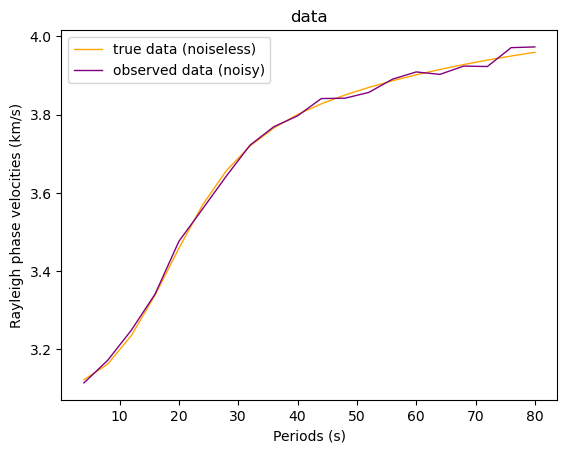

In [13]:
ax = plot_data(d_true, color="orange", label="true data (noiseless)")
plot_data(d_obs, ax=ax, color="purple", label="observed data (noisy)")
ax.legend();

### Define `BaseProblem`

In [14]:
sw_problem = cofi.BaseProblem()

### Optimisation (with damping)

#### Prepare `BaseProblem` for optimisation

In [15]:
n_dims = 17

# init_thicknesses = np.hstack((np.array([10, 10, 15]), np.ones((n_dims//2-3,))*20))
init_thicknesses = np.ones((n_dims//2,)) * 15
# init_vs = np.linspace(3, 4.5, n_dims//2+1)
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

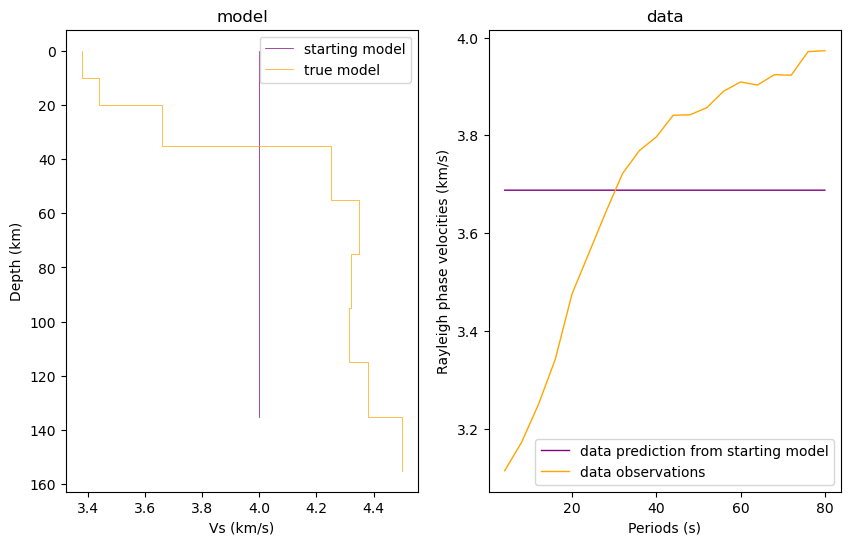

In [16]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
plot_model(init_model, ax=ax1, label="starting model", alpha=1, color="purple")
plot_model(true_model, ax=ax1, label="true model", alpha=1, color="orange")
plot_data(forward_sw(init_model), ax=ax2, label="data prediction from starting model", color="purple")
plot_data(d_obs, ax=ax2, label="data observations", color="orange")
ax1.legend()
ax2.legend();

In [17]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

# my_vs_reg = cofi.utils.QuadraticReg(
#     weighting_matrix="damping", 
#     model_shape=(n_dims//2+1,), 
#     reference_model=init_vs
# )
# my_reg_diag = np.zeros((n_dims,))
# my_reg_diag[::2] = my_vs_reg.matrix.diagonal()
# my_reg_matrix = np.diag(my_reg_diag)

# my_reg = cofi.utils.QuadraticReg(
#     weighting_matrix=my_reg_matrix,
#     model_shape=(n_dims,),
#     reference_model=init_model
# )

In [18]:
def my_objective(model, lamda=1.0):
    d_pred = forward_sw(model)
    data_misfit = np.sum((d_obs - d_pred) ** 2)
    reg = my_reg(model)
    return data_misfit + lamda * reg

def my_objective_gradient(model, lamda=1.0):
    d_pred = forward_sw(model)
    jac = jacobian_sw(model)
    data_misfit_grad = -2 * jac.T @ (d_obs - d_pred)
    reg_grad = my_reg.gradient(model)
    return data_misfit_grad + lamda * reg_grad

def my_objective_hessian(model, lamda=1.0):
    jac = jacobian_sw(model)
    data_misfit_hess = 2 * jac.T @ jac
    reg_hess = my_reg.hessian(model)
    return data_misfit_hess + reg_hess

In [19]:
lamda = 0.1

sw_problem.set_objective(my_objective, args=[lamda])
sw_problem.set_gradient(my_objective_gradient, args=[lamda])
sw_problem.set_hessian(my_objective_hessian, args=[lamda])
sw_problem.set_initial_model(init_model)

#### Define `InversionOptions`

In [20]:
inv_options_optimiser = cofi.InversionOptions()
inv_options_optimiser.set_tool("scipy.optimize.minimize")

#### Define `Inversion` and run

In [21]:
inversion_optimiser = cofi.Inversion(sw_problem, inv_options_optimiser)
inv_result_optimiser = inversion_optimiser.run()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


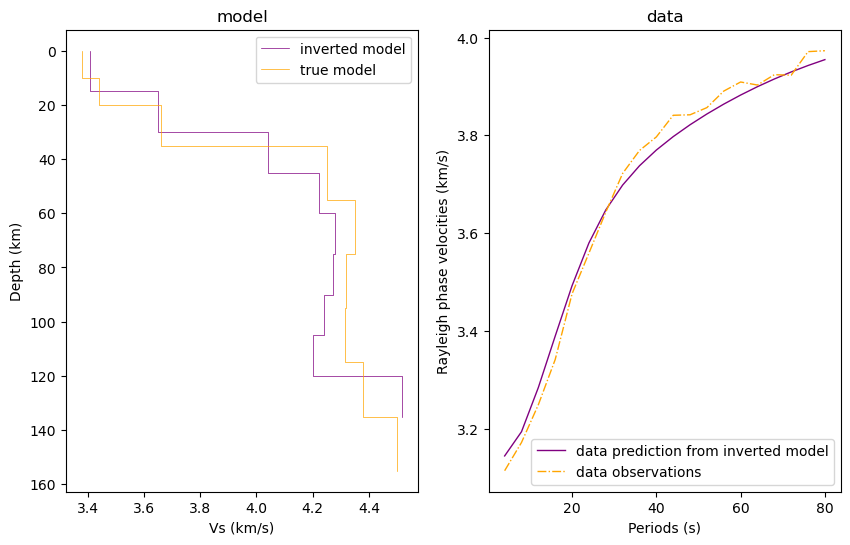

In [22]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))

plot_model(
    inv_result_optimiser.model, 
    ax=ax1, 
    color="purple", 
    alpha=1, 
    label="inverted model"
)
plot_model(true_model, ax=ax1, color="orange", alpha=1, label="true model")
ax1.legend();

plot_data(
    forward_sw(inv_result_optimiser.model), 
    ax=ax2, 
    color="purple", 
    label="data prediction from inverted model"
)
plot_data(d_obs, ax=ax2, color="orange", linestyle="-.", label="data observations")
ax2.legend();

### Optimisation II (no damping)

In [23]:
lamda = 0

sw_problem2 = cofi.BaseProblem()
sw_problem2.set_objective(my_objective, args=[lamda])
sw_problem2.set_gradient(my_objective_gradient, args=[lamda])
sw_problem2.set_hessian(my_objective_hessian, args=[lamda])
sw_problem2.set_initial_model(init_model)

In [24]:
inversion_optimiser2 = cofi.Inversion(sw_problem2, inv_options_optimiser)
inv_result_optimiser2 = inversion_optimiser2.run()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


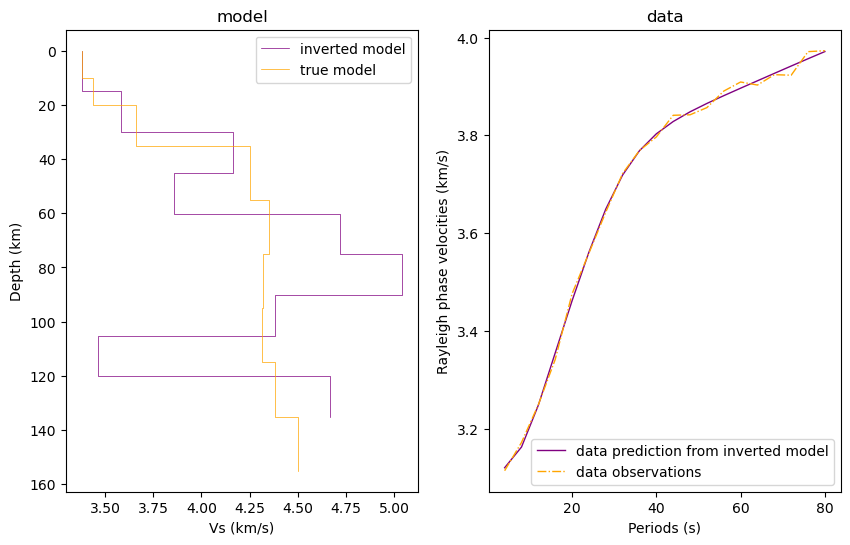

In [25]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))

plot_model(
    inv_result_optimiser2.model, 
    ax=ax1, 
    color="purple", 
    alpha=1, 
    label="inverted model"
)
plot_model(true_model, ax=ax1, color="orange", alpha=1, label="true model")
ax1.legend();

plot_data(
    forward_sw(inv_result_optimiser2.model), 
    ax=ax2, 
    color="purple", 
    label="data prediction from inverted model"
)
plot_data(d_obs, ax=ax2, color="orange", linestyle="-.", label="data observations")
ax2.legend();

### Fixed-dimensional Sampling

#### Prepare `BaseProblem` for fixed-dimensional sampling

In [26]:
thick_min = 5
thick_max = 30
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < 2) | (vs > 5)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = -np.log(30 - 5) * len(thicknesses) - np.log(5 - 2) * len(vs)
    return log_prior

In [27]:
Cdinv = np.eye(len(d_obs))/(noise_level**2)      # inverse data covariance matrix

def my_log_likelihood(model):
    try:
        d_pred = forward_sw(model)
    except:
        return float("-inf")
    residual = d_obs - d_pred
    return -0.5 * residual @ (Cdinv @ residual).T

In [28]:
n_walkers = 40

my_walkers_start = np.zeros((n_walkers, n_dims))
for i in range(n_walkers):
    thicknesses = np.random.uniform(thick_min, thick_max, n_dims//2)
    vs = np.random.uniform(vs_min, vs_max, n_dims//2+1)
    my_walkers_start[i,:] = form_layercake_model(thicknesses, vs)

In [29]:
sw_problem.set_log_prior(my_log_prior)
sw_problem.set_log_likelihood(my_log_likelihood)

##### TODO sample the prior

#### Define `InversionOptions`

In [32]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers, 
    nsteps=1_000, 
    initial_state=my_walkers_start, 
    skip_initial_state_check=True, 
    progress=True
)

#### Define `Inversion` and run

In [33]:
inversion_fixed_d_sampler = cofi.Inversion(sw_problem, inv_options_fixed_d_sampling)

np.seterr(all="ignore")

inv_result_fixed_d_sampler = inversion_fixed_d_sampler.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.04it/s]


In [37]:
import arviz as az

labels = ["v0", "t0", "v1", "t1", "v2", "t2", "v3", "t3", "v4", "t4", "v5", "t5", "v6", "t6", "v7", "t7", "v8"]

sampler = inv_result_fixed_d_sampler.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [39]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 40, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables: (12/17)
    v0       (chain, draw) float64 4.056 4.056 4.056 4.056 ... 3.347 3.347 3.347
    t0       (chain, draw) float64 15.55 15.55 15.55 15.55 ... 8.147 8.147 8.147
    v1       (chain, draw) float64 4.559 4.559 4.559 4.559 ... 3.521 3.521 3.521
    t1       (chain, draw) float64 24.12 24.12 24.12 24.12 ... 23.11 23.11 23.11
    v2       (chain, draw) float64 2.378 2.378 2.378 2.378 ... 4.288 4.288 4.288
    t2       (chain, draw) float64 28.12 28.12 28.12 28.12 ... 28.94 28.94 28.94
    ...       ...
    t5       (chain, draw) float64 13.07 13.07 13.07 13.07 ... 7.242 7.242 7.242
    v6       (chain, draw) float64 4.562 4.562 4.562 4.562 ... 3.372 3.372 3.372
    t6       (chain, draw) float64 22.94 22.94 22.94 22.94 ... 7.712 7.712 7.712
    v7       (chain, draw) float64 3.891 3.891 3.891 3.891 ... 4.844 4.844 4.844
    t7       (chain, draw) float64 22.76 22.76 22.76 22.76 ... 17.66 17.66 17.66
    v8       (chain, draw) float64 3.854 3.854 3.854 3.854 ... 4.498 4.498 4.498
Attributes:
    created_at:                 2024-01-30T23:58:32.438413
    arviz_version:              0.17.0
    inference_library:          emcee
    inference_library_version:  3.1.4

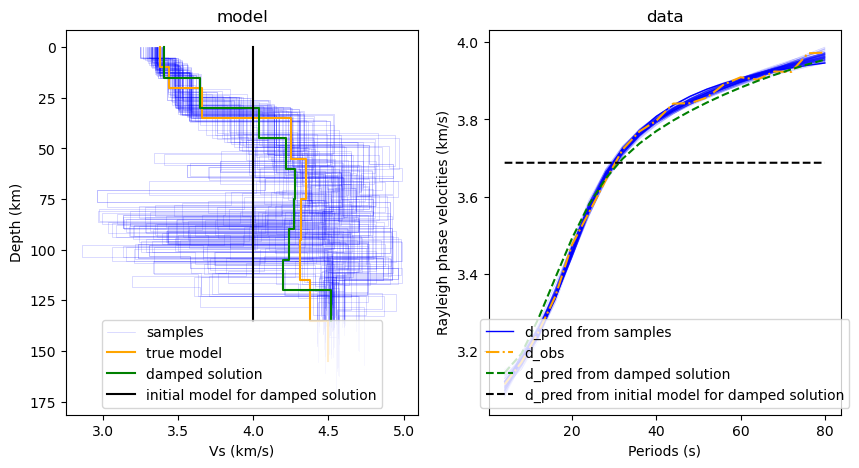

In [59]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for idx in rand_indices:
    sample = flat_samples[idx]
    plot_model(sample, ax=ax1)
    plot_data(forward_sw(sample), ax=ax2, alpha=0.2, lw=0.5)
plot_model(flat_samples[rand_indices[0]], ax=ax1, label="samples")
plot_data(forward_sw(flat_samples[rand_indices[0]]), ax=ax2, label="d_pred from samples")

plot_model(true_model, ax=ax1, alpha=1, lw=1.5, color="orange", label="true model")
plot_data(d_obs, ax=ax2, alpha=1, lw=1.5, linestyle="-.", color="orange", label="d_obs")

plot_model(inv_result_optimiser.model, ax=ax1, alpha=1, lw=1.5, color="green", label="damped solution")
plot_data(forward_sw(inv_result_optimiser.model), ax=ax2, alpha=1, lw=1.5, linestyle="--", color="green", label="d_pred from damped solution")

plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="black", label="initial model for damped solution")
plot_data(forward_sw(init_model), ax=ax2, alpha=1, lw=1.5, linestyle="--", color="black", label="d_pred from initial model for damped solution")

ax1.legend(loc="lower center")
ax2.legend(loc="lower center");

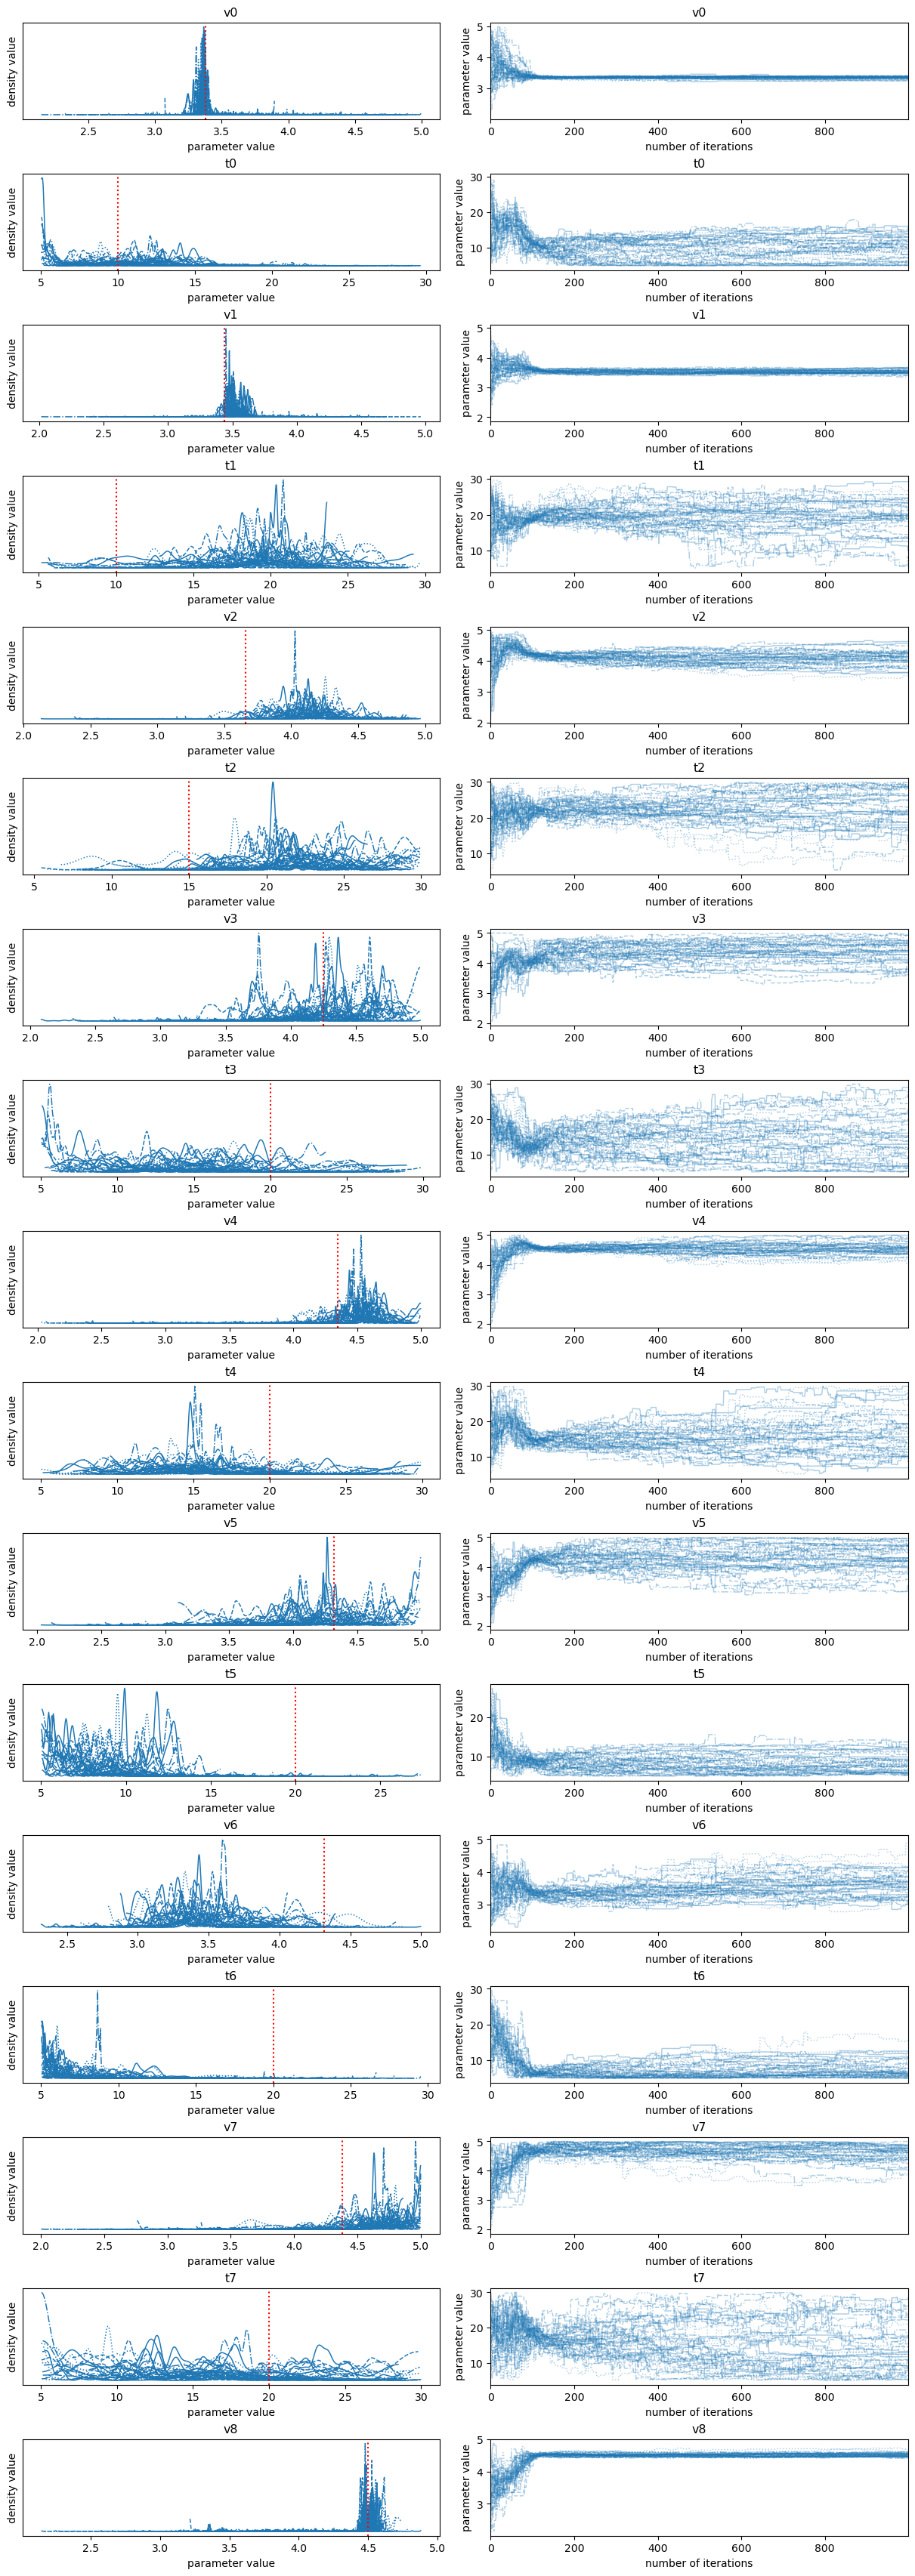

In [41]:
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True});

for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

### Trans-dimensional Sampling

#### Prepare utilities for trans-dimensional sampling

In [ ]:
def forward_for_bayesbay(state):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    thicknesses = voronoi_to_layercake(voronoi_sites)
    model = form_layercake_model(thicknesses, vs)
    return forward_sw(model)

In [ ]:
targets = [bayesbay.Target("rayleigh", d_obs, covariance_mat_inv=1/noise_level**2)]
fwd_funcs = [forward_for_bayesbay]
my_log_likelihood_ratio = bayesbay.LogLikelihood(targets, fwd_funcs)

In [ ]:
param_vs = bayesbay.parameters.UniformParameter(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [ ]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=15, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_functions

In [ ]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

#### Define `InversionOptions`

In [ ]:
inv_options_trans_d_sampling = cofi.InversionOptions()
inv_options_trans_d_sampling.set_tool("bayesbay")
inv_options_trans_d_sampling.set_params(
    walkers_starting_models=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood_ratio,
    n_chains=4, 
    n_cpus=4, 
    n_iterations=3_000, 
    burnin_iterations=1_000,
    verbose=True,
    save_every=200, 
)

#### Define `Inversion` and run

In [ ]:
inversion_trans_d_sampler = cofi.Inversion(sw_problem, inv_options_trans_d_sampling)
inv_result_trans_d_sampler = inversion_trans_d_sampler.run()

In [ ]:
inverted_models = inv_result_trans_d_sampler.models

## Field data example

## Watermark

In [ ]:
watermark_list = ["cofi", "numpy", "matplotlib", "scipy", "emcee", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))